#Preprocessing data in the form of CSV files and performing classification of movie reviews as Positive and Negative reviews based on sentiment analysis and trying various different ML models and comapring performance metrics.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#In data processing we need to process the data by doing the following
1.We need first drop NULL rows from the train.csv by using dropna with the subset of movieid,reviewText and reviewerName.

2.Then we needed to remove duplicate values where no two movies can have same movieid.

3.In movie.csv we only care whether movieid is null or not so we drop only rows which have null movieid.

4.On movieid we join train.csv and movie.csv and joining them on the movieid column.

5.similarly process the test data by removing null values and removing duplicate values

In [2]:
# reading two csv files
import pandas as pd
train_df=pd.read_csv('/content/drive/MyDrive/movie.csv')
print("First 5 elements of the dataset:\n")
print(train_df.head())
print("\n\n")
#It is given 0 is negative and 1 is positive sentiment
print("Number of reviews:",len(train_df))
print("\n\n")
print("Number of positive and negative sentiment reviews:\n",train_df["label"].value_counts())
#check whether there are any missing values
print("Check if there are any NaN values:\n")
print(train_df.isna().sum())#No NaN values hence we shall proceed

First 5 elements of the dataset:

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1



Number of reviews: 40000



Number of positive and negative sentiment reviews:
 0    20019
1    19981
Name: label, dtype: int64
Check if there are any NaN values:

text     0
label    0
dtype: int64


#For more randomised training data we will shuffle the training data so that the model does not get biased based on training data order.

In [3]:
train_df_shuffled=train_df.sample(frac=1,random_state=42)

In [4]:
#train dataset
train_df_shuffled.head()

,text,label
32823,The central theme in this movie seems to be co...,0
16298,"An excellent example of ""cowboy noir"", as it's...",1
28505,The ending made my heart jump up into my throa...,0
6689,Only the chosen ones will appreciate the quali...,1
26893,"This is a really funny film, especially the se...",1


In [5]:
#number of examples in each class
train_df_shuffled.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

#Using our good friend train_test_split we split the training dataset into testing and validating dataset and we will have validation data size as 10 percent of the training data

In [6]:
#split data into training and validation datasets
from sklearn.model_selection import train_test_split
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                       train_df_shuffled["label"].to_numpy(),
                                                                       test_size=0.1,
                                                                       random_state=42)

In [7]:
#check the lengths
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(36000, 4000, 36000, 4000)

#We tokenize for convert the text to numbers using the CountVectorizer which returns a sparse matrix and also use the tfid Transformer from the feature extraction library to get a effective representation of textual reviews to numbers for our ML model to learn on

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()
train_vectorized=count_vect.fit_transform(train_sentences)

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer=TfidfTransformer(use_idf=False).fit(train_vectorized)
train_tf=tf_transformer.transform(train_vectorized)

#The first model we will use for classifying the movie reviews is the classic naive bayes classifier which is normally a good starting point for classification problems

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0=Pipeline([
    ('vect', CountVectorizer()),
    ("tfisf",TfidfTransformer()),
    ("clf",MultinomialNB())
])
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfisf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [11]:
#Evaluate model 0
model_0_results=model_0.score(val_sentences,val_labels)
model_0_results

0.852

In [12]:
#Make predictions
model_0_preds=model_0.predict(val_sentences)
model_0_preds[:20]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1])

In [13]:
train_labels[:20]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [14]:
#function to evaluate a model based on accuracy,precision,recall and F1-score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_preds):
  model_accuracy=accuracy_score(y_true,y_preds)
  #calculating model precison,recall and f1 score using weighted average
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_preds,average="weighted")
  model_results={"accuracy":model_accuracy,
                 "precision":model_precision,
                 "recall":model_recall,
                 "f1":model_f1}
  return model_results

In [15]:
#get baseline model results
model_0_results=calculate_results(val_labels,model_0_preds)
model_0_results

{'accuracy': 0.852,
 'precision': 0.85301153108443,
 'recall': 0.852,
 'f1': 0.8519287876275655}

#The second model we are going to check on is a basic logistic Regression model which can be used for classification problems as well

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
logistic=LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)
distributions=dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])
model_1=Pipeline([
     ('vect',CountVectorizer()),
     ('tfidf',TfidfTransformer()),
     ('clf',RandomizedSearchCV(logistic, distributions, random_state=0))
])
model_1.fit(train_sentences,train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomizedSearchCV(estimator=LogisticRegression(max_iter=200,
                                                                 random_state=0,
                                                                 solver='saga',
                                                                 tol=0.01),
                                    param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7841b909cd00>,
                                                         'penalty': ['l2',
                                                                     'l1']},
                                    random_state=0))])

In [17]:
#Evaluate model 1
model_1_score=model_1.score(val_sentences,val_labels)
model_1_score

0.9025

In [18]:
model_1_preds=model_1.predict(val_sentences)
model_1_preds[:20]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [19]:
model_1_results=calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 0.9025,
 'precision': 0.9026039536481774,
 'recall': 0.9025,
 'f1': 0.9024867366045708}

#The third Model we are going to use is a Multi Layer perceptron (MLP) classifier from the sklearn neural netwroks library

In [20]:
from sklearn.neural_network import MLPClassifier
clf=MLPClassifier(max_iter=5,random_state=42)
model_2= Pipeline([
    ('vect',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf', MLPClassifier(max_iter=5,random_state=42))
])
model_2.fit(train_sentences,train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(max_iter=7))])

In [21]:
model_2_score=model_2.score(val_sentences,val_labels)
model_2_score

0.8555

In [22]:
model_2_preds=model_2.predict(val_sentences)
model_2_preds[:20]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1])

In [23]:
model_2_results=calculate_results(val_labels,model_2_preds)
model_2_results

{'accuracy': 0.8555,
 'precision': 0.8568056561455972,
 'recall': 0.8555,
 'f1': 0.8553272832405834}

#The Fourth Model we will be using for this dataset is the Gradient Boosting

---

Gradient Machine Leanring Model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
model_3= Pipeline([
    ('vect',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf',GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=42))
])
model_3.fit(train_sentences,train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=42))])

In [25]:
model_3_score=model_3.score(val_sentences,val_labels)
model_3_score

0.8285

In [26]:
model_3_preds=model_3.predict(val_sentences)
model_3_preds[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1])

In [27]:
model_3_results=calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 0.8285,
 'precision': 0.828858040460582,
 'recall': 0.8285,
 'f1': 0.8284249218261414}

#The Fifth Model for text classification of Movie Reviews is the Linear Support Vector Classifier(Linear SVC)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Define the hyperparameter grid for LinearSVC
param_grid = {
    'Linear SVC__C': [0.01, 0.1, 1.0, 10.0],  # C parameter for LinearSVC
    'Linear SVC__penalty': ['l2'],            # Penalty type
    'Linear SVC__dual': [False],              # Dual or primal formulation
    'Linear SVC__max_iter': [200, 500, 1000]  # Maximum number of iterations
}

# Create the pipeline
model_4 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('Linear SVC', LinearSVC(random_state=42))
])

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model_4,
    param_distributions=param_grid,
    cv=5,                # Cross-validation strategy
    scoring='accuracy', # Scoring metric
    n_iter=10,           # Number of random combinations to try
    random_state=42,
    n_jobs=-1            # Use all available CPU cores
)

# Fit the RandomizedSearchCV on your training data
random_search.fit(train_sentences, train_labels)

# Print the best hyperparameters and mean test score
print("Best Hyperparameters:")
print(random_search.best_params_)
print("Best Mean Test Score (Accuracy):")
print(random_search.best_score_)

Best Hyperparameters:
{'Linear SVC__penalty': 'l2', 'Linear SVC__max_iter': 1000, 'Linear SVC__dual': False, 'Linear SVC__C': 1.0}
Best Mean Test Score (Accuracy):
0.8974444444444444


In [41]:
# Get the best hyperparameters from the GridSearchCV output
linear_svc_best_params = random_search.best_params_

# Extract only the LinearSVC hyperparameters without the prefix
linear_svc_best_params = {key.replace('Linear SVC__', ''): value for key, value in linear_svc_best_params.items() if key.startswith('Linear SVC__')}

# Create a new instance of the LinearSVC model with the best hyperparameters
best_linear_svc = LinearSVC(**linear_svc_best_params, random_state=42)

# Create the pipeline using CountVectorizer, TfidfTransformer, and the best LinearSVC
model_4 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('linear_svc', best_linear_svc)
])

# Fit the new model on your complete training dataset
model_4.fit(train_sentences, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('linear_svc', LinearSVC(dual=False, random_state=42))])

In [42]:
model_4_score=model_4.score(val_sentences,val_labels)
model_4_score

0.90025

In [43]:
model_4_preds=model_4.predict(val_sentences)
model_4_preds[:20]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [44]:
model_4_results=calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 0.90025,
 'precision': 0.9002725647765828,
 'recall': 0.90025,
 'f1': 0.9002450180465539}

#We will now take a look at using Random forest Classifer as the sixth model in our study

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Define the pipeline
model_5 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(random_state=42)),
])

model_5.fit(train_sentences, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier(random_state=42))])

In [32]:
model_5_results=model_5.score(val_sentences,val_labels)
model_5_results

0.83725

In [33]:
model_5_preds=model_5.predict(val_sentences)
model_5_preds[:20]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

In [34]:
model_5_results=calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 0.83725,
 'precision': 0.8372623222359001,
 'recall': 0.83725,
 'f1': 0.8372519225373649}

#The last and final Model is the SGD(Stochastic Gradient Descent) Model for classification

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the pipeline for SGDClassifier
model_6 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgdclassifier', SGDClassifier())
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01],
    'sgdclassifier__penalty': ['l2', 'l1'],
    'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber']
}

grid_search_sgd = GridSearchCV(model_6, param_grid, cv=5, scoring='accuracy')
grid_search_sgd.fit(train_sentences, train_labels)

print("Best Hyperparameters:")
print(grid_search_sgd.best_params_)
print("Best Mean Test Score (Accuracy):")
print(grid_search_sgd.best_score_)

Best Hyperparameters:
{'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'modified_huber', 'sgdclassifier__penalty': 'l2'}
Best Mean Test Score (Accuracy):
0.8999722222222222


In [36]:
# Get the best hyperparameters from the GridSearchCV output
sgd_best_params = grid_search_sgd.best_params_

# Extract only the LinearSVC hyperparameters without the prefix
sgd_best_params = {key.replace('sgdclassifier__', ''): value for key, value in sgd_best_params.items() if key.startswith('sgdclassifier__')}

# Create a new instance of the LinearSVC model with the best hyperparameters
best_sgd = SGDClassifier(**sgd_best_params, random_state=42)

# Create the pipeline using CountVectorizer, TfidfTransformer, and the best LinearSVC
model_6 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgdclassifier', best_sgd)
])

# Fit the new model on your complete training dataset
model_6.fit(train_sentences, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('sgdclassifier',
                 SGDClassifier(loss='modified_huber', random_state=42))])

In [37]:
model_6_results=model_6.score(val_sentences,val_labels)
model_6_results

0.90425

In [38]:
model_6_preds=model_6.predict(val_sentences)
model_6_preds[:20]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [39]:
model_6_results=calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 0.90425,
 'precision': 0.9043140081025732,
 'recall': 0.90425,
 'f1': 0.904240788176299}

#Compare performance of each of our models by combine model results into a dataframe

In [45]:
all_models_results=pd.DataFrame({"1.Naive Bayes":model_0_results,
                                 "2.Logistic Regression":model_1_results,
                                 "3.MLP classifier":model_2_results,
                                 "4.Gradient Booster":model_3_results,
                                 "5.LinearSVC":model_4_results,
                                 "6.RandomForest":model_5_results,
                                 "7.Stochastic Gradient Descent":model_6_results})
all_models_results=all_models_results.transpose()

Tabular representation of ML models

In [46]:
all_models_results

,accuracy,precision,recall,f1
1.Naive Bayes,0.85200,0.853012,0.85200,0.851929
2.Logistic Regression,0.90250,0.902604,0.90250,0.902487
3.MLP classifier,0.85550,0.856806,0.85550,0.855327
4.Gradient Booster,0.82850,0.828858,0.82850,0.828425
5.LinearSVC,0.90025,0.900273,0.90025,0.900245
6.RandomForest,0.83725,0.837262,0.83725,0.837252
7.Stochastic Gradient Descent,0.90425,0.904314,0.90425,0.904241


#Plotting F1 scores,accuracy,recall and precision for a visual comparison

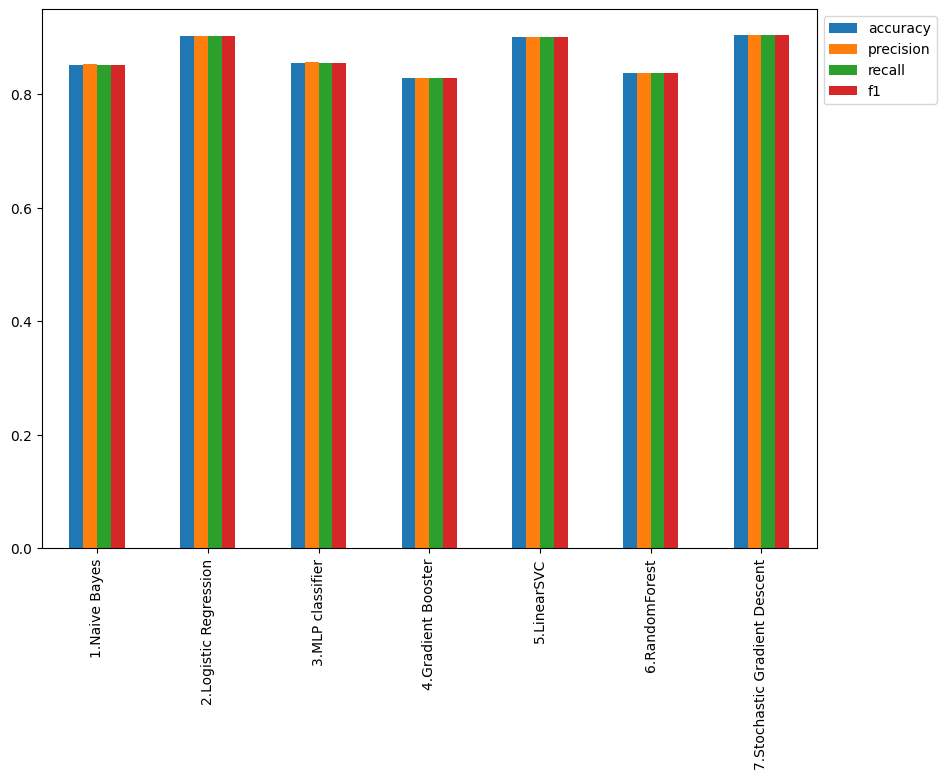

In [47]:
all_models_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

Sorting our models results by accuracy scores to decide which is the best model

<Axes: >

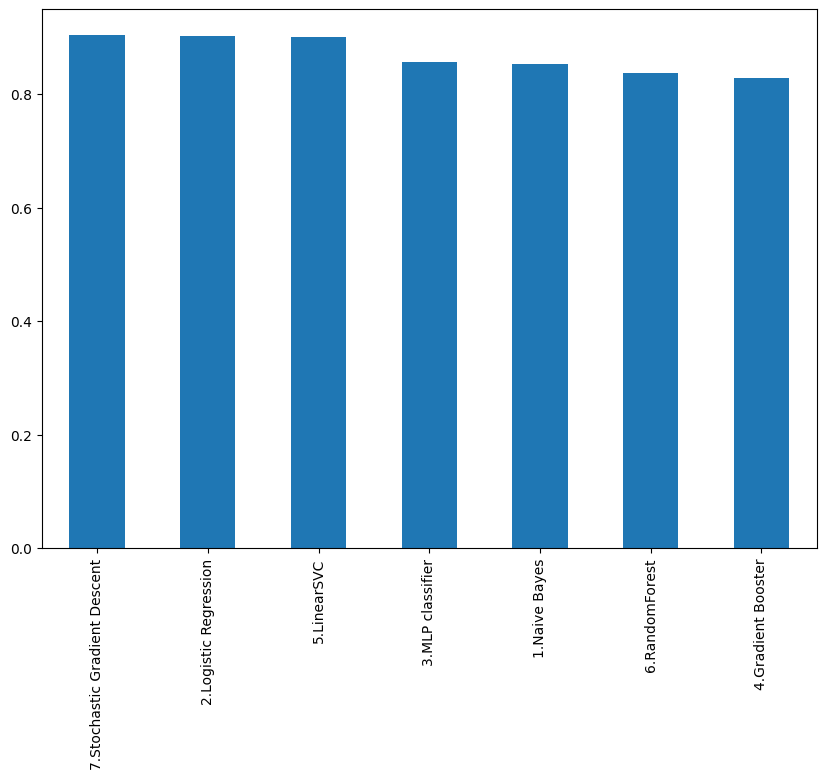

In [48]:
all_models_results.sort_values("accuracy",ascending=False)["accuracy"].plot(kind="bar",figsize=(10,7))

#making a confusion matrix for the best performing model(Logistic Regression)

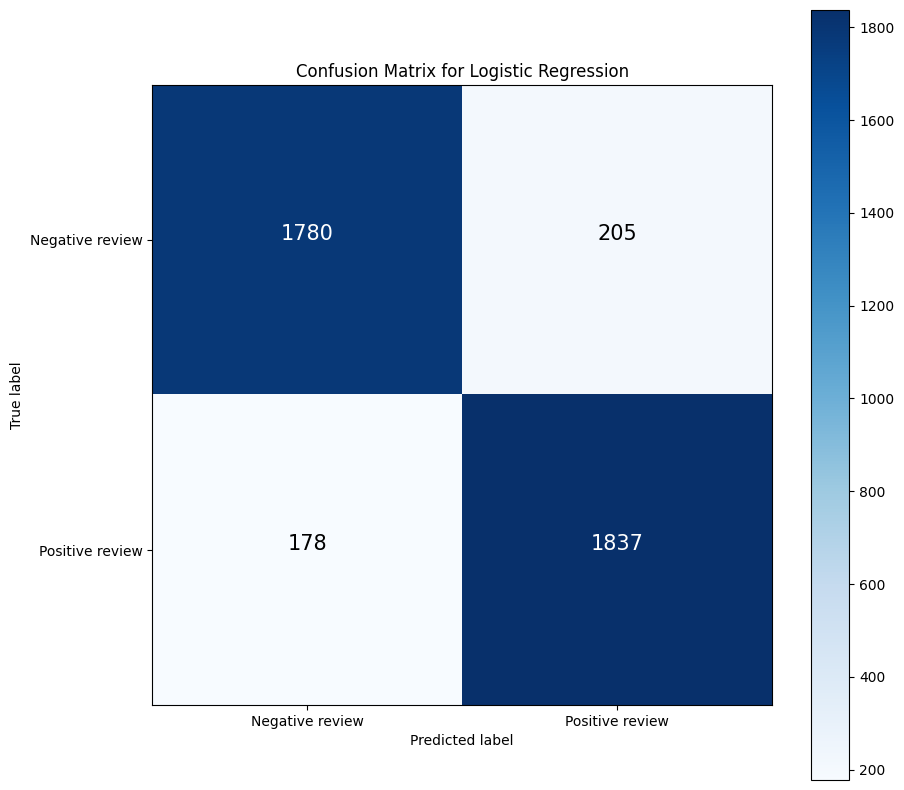

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
cm=confusion_matrix(val_labels,model_6_preds)
n_classes=cm.shape[0]

fig,ax=plt.subplots(figsize=(10, 10))
cax=ax.matshow(cm,cmap=plt.cm.Blues)
fig.colorbar(cax)
labels=np.array(["Negative review","Positive review"])

ax.set(title="Confusion Matrix for Logistic Regression",xlabel="Predicted label",ylabel="True label",xticks=np.arange(n_classes),yticks=np.arange(n_classes), xticklabels=labels, yticklabels=labels)
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

threshold=(cm.max()+cm.min())/2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]}",horizontalalignment="center",color="white" if cm[i,j]>threshold else "black",size=15)